# Exercise 4: Vocoder and Quantization

In [1]:
import librosa
import numpy as np
from scipy.linalg import solve_toeplitz
from scipy.signal import get_window, freqz, lfilter
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 4)

In [2]:
# "Import" functions from previous exercises

import requests

gist = requests.get(
    "https://gist.githubusercontent.com/iibrahimli/3c50f73020c78aeee1de68ae5a0ba5e7/raw/import_funcs.py"
).text
print("Downloaded import_funcs.py")
exec(gist)

import_function_from_ipynb(
    "exercise1.ipynb",
    [
        "plot_signal",
        "my_windowing",
        "acf",
        "estimate_fundamental_frequency",
    ],
)
import_function_from_ipynb(
    "exercise2.ipynb",
    [
        "compute_stft",
    ]
)

Downloaded import_funcs.py
Found exercise1.ipynb: /Users/imran/Desktop/studies/suse_23/speech_sp/Exercise1/exercise1.ipynb
Executed function plot_signal
Executed function my_windowing
Executed function acf
Executed function estimate_fundamental_frequency
Successfully imported functions: ['plot_signal', 'my_windowing', 'acf', 'estimate_fundamental_frequency']
Found exercise2.ipynb: /Users/imran/Desktop/studies/suse_23/speech_sp/Exercise2/exercise2.ipynb
Executed function compute_stft
Successfully imported functions: ['compute_stft']


In [136]:
def plot_log_spectrogram(
    signal: np.ndarray,
    sampling_rate: int,
    frame_length: int = 32,
    frame_shift: int = 8,
    max_freq: int = 8000,
    fig: plt.Figure = None,
    ax: plt.Axes = None,
) -> None:
    """Plot the log spectrogram of a signal."""
    m_stft, v_freq, v_time = compute_stft(
        signal,
        sampling_rate,
        frame_length,
        frame_shift,
        get_window("hann", frame_length * sampling_rate // 1000),
    )

    magnitude = 10 * np.log10(np.maximum(np.square(np.abs(m_stft.T)), 10 ** (-15)))

    # limit frequency range to [0, max_freq]
    v_freq = v_freq[v_freq <= max_freq]
    magnitude = magnitude[: len(v_freq), :]

    if fig is None and ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    im = ax.imshow(
        magnitude,
        cmap="viridis",
        origin="lower",
        extent=[v_time[0], v_time[-1], v_freq[0], v_freq[-1]],
        aspect="auto",
    )

    # fig.colorbar(im, orientation="vertical", pad=0.01)
    # im.colorbar.set_label("Magnitude [dB]", rotation=270, labelpad=15)

    # ax.set_title(f"Spectrogram \n (frame length: {frame_length} ms, frame shift: {frame_shift} ms)")
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Frequency [Hz]")
    ax.set_ylim(0, max_freq)
    # ax.set_yscale("log")

## 2.1 Load `female8khz.wav`

In [137]:
x, fs = librosa.core.load("Audio/female8khz.wav")
print(f"Samples: {len(x)}, sampling frequency: {fs} Hz")

Samples: 49613, sampling frequency: 22050 Hz


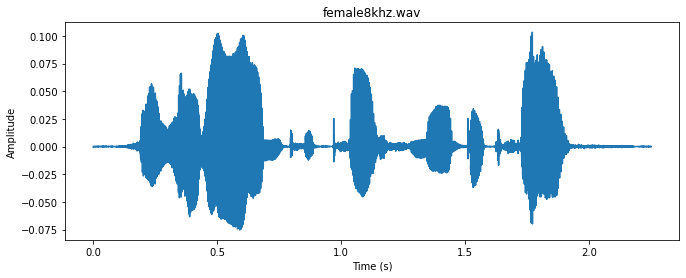

In [138]:
plot_signal(x, fs, title="female8khz.wav")

In [139]:
# Window the signal
frame_length = 32 # ms
frame_shift = 8 # ms
N = frame_length * fs // 1000
R = frame_shift * fs // 1000
print(f"Frame length: {N} samples, frame shift: {R} samples")

m_frames, v_time_frame = my_windowing(x, fs, frame_length, frame_shift)
m_frames.shape, v_time_frame.shape

Frame length: 705 samples, frame shift: 176 samples


((278, 705), (278,))

- Why do we segment the signal prior to analysis instead of processing the whole signal at once?
  - Because the signal is not stationary, and the analysis is only valid for a short period of time.
- Is a segment length of 32 ms appropriate? Why or why not?
  - It provides a reasonable trade-off between frequency and time resolution.

## 2.2 Signal power

In [140]:
def compute_power(x: np.ndarray) -> float:
    return np.sum(x ** 2) / len(x)

In [141]:
# Compute power of each frame
v_power = np.apply_along_axis(compute_power, 1, m_frames)
v_power.shape

(278,)

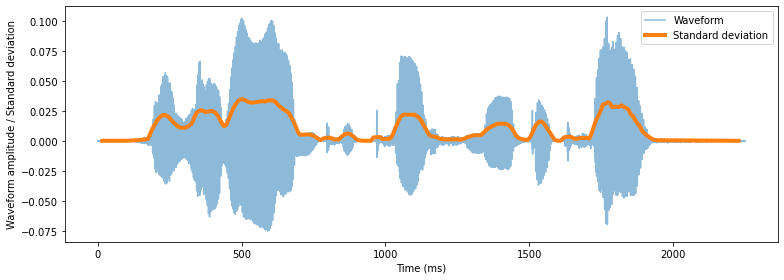

In [142]:
# Plot waveform and standard deviation
plt.plot(np.arange(len(x)) / fs * 1000, x, alpha=0.5, label="Waveform")
plt.plot(v_time_frame, np.sqrt(v_power), linewidth=4, label="Standard deviation")
plt.xlabel("Time (ms)")
plt.ylabel("Waveform amplitude / Standard deviation")
plt.tight_layout()
plt.legend()
plt.show()

## 2.3 Voiced / unvoiced decision

- Explain differences in the creation of speech for voiced and unvoiced sounds.
  - Voiced sounds are created by the vibration of the vocal folds, which creates a quasi-periodic signal. Unvoiced sounds are created by turbulent air flow, which creates a random signal.
- Why might the number of zero crossings provide valuable information for the voiced/unvoiced decision?
  - Since voiced sounds are quasi-periodic, they have a lower number of zero crossings. Unvoiced sounds are random and contain higher-frequency components, they have a higher number of zero crossings.
- Think of a way how you can efficiently detect a zero crossing between two samples. How can you realize that in
Python?
   - The sign of the two consecutive samples is different if there is a zero crossing. We could multiply the two samples and check if the result is negative.

In [143]:
def plot_signal_and_zero_crossings(x: np.ndarray, title: str = ""):
    signs = np.sign(x)
    zero_crossings = signs * np.roll(signs, 1) < 0
    zero_crossings = np.where(zero_crossings)[0]

    plt.plot(x, label="Frame")
    plt.plot(zero_crossings, np.zeros(len(zero_crossings)), ".", c="red", label="Zero crossings")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.title(title + f" ({len(zero_crossings)} zero crossings)")
    
    # clean up legend
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1, 0]
    plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
    
    plt.show()

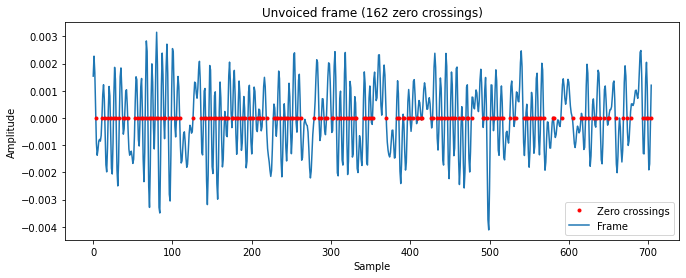

In [144]:
plot_signal_and_zero_crossings(m_frames[150], title="Unvoiced frame")

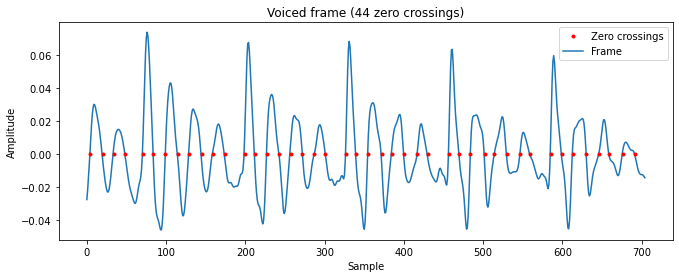

In [145]:
plot_signal_and_zero_crossings(m_frames[230], title="Voiced frame")

In [146]:
def n_zero_crossings(x: np.ndarray) -> int:
    signs = np.sign(x)
    zero_crossings = signs * np.roll(signs, 1) < 0
    return np.sum(zero_crossings) / N

In [179]:
def is_voiced(x: np.ndarray, threshold: float) -> int:
    """Return 1 for voiced, 0 for unvoiced."""
    return 1 if n_zero_crossings(x) < threshold else 0

In [200]:
# Threshold on number of zero crossings per sample
threshold = 0.11

v_voiced = np.apply_along_axis(is_voiced, 1, m_frames, threshold)
v_voiced.shape

(278,)

Output matches np.fft.rfft: True


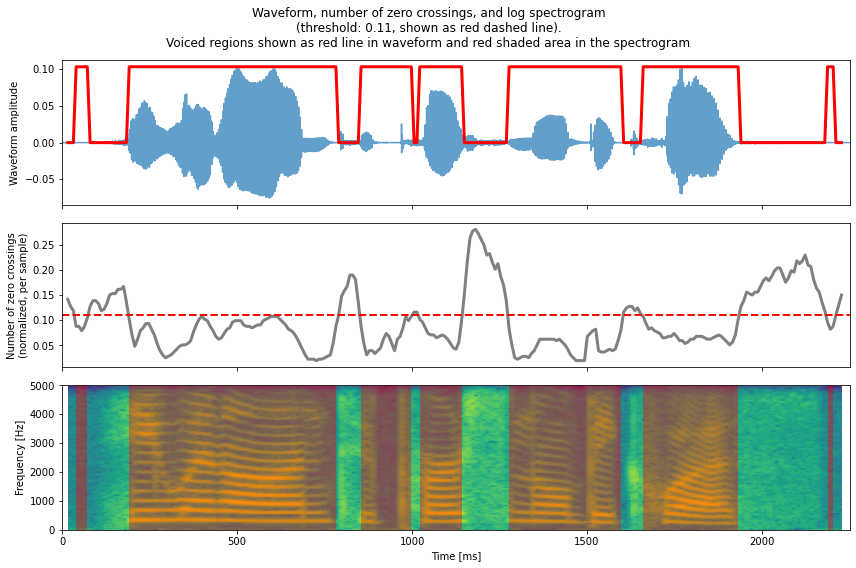

In [202]:
# Plot waveform and number of zero crossings
max_ms = len(x) / fs * 1000

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
axs[0].plot(np.arange(len(x)) / fs * 1000, x, alpha=0.7)
axs[0].plot(v_time_frame, v_voiced * np.max(x), linewidth=3, c="red", label="Voiced")
axs[0].set_ylabel("Waveform amplitude")
axs[0].set_xlim(0, max_ms)

axs[1].plot(v_time_frame, np.apply_along_axis(n_zero_crossings, 1, m_frames), linewidth=3, c="gray")
axs[1].axhline(threshold, c="red", linestyle="--", linewidth=2)
axs[1].set_ylabel(f"Number of zero crossings\n(normalized, per sample)")
axs[1].set_xlim(0, max_ms)

max_freq = 5000
plot_log_spectrogram(x, fs, frame_length, frame_shift, max_freq=5000, fig=fig, ax=axs[2])
# plot v_voiced as red shaded area in spectrogram
axs[2].fill_between(
    v_time_frame,
    0,
    max_freq,
    where=v_voiced == 1,
    facecolor="red",
    alpha=0.4,
    transform=axs[2].get_xaxis_transform(),
)

fig.suptitle(
    f"Waveform, number of zero crossings, and log spectrogram\n"
    f"(threshold: {threshold}, shown as red dashed line).\n"
    "Voiced regions shown as red line in waveform and red shaded area in the spectrogram"
)
plt.tight_layout()

- In general: are all speech sounds either voiced or unvoiced? Can you think of other speech sounds? Examples?
  - TODO